## Set-up

In [853]:
import copy
import pandas as pd
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot(sigs, title="", figsize=(21, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    for sig in sigs:
        ax.plot(sig)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.tick_params(axis="both")
    fig.tight_layout()
    return fig, ax

def generate_triangles(length=40000, period=256, amplitude=10):
    assert period % 4 == 0
    amp = amplitude / 2
    period = int(period / 4)

    line = np.linspace(0, amp, period)
    wave = np.concatenate([line, -1 * line + amp, -1 * line, line - amp])
    n_wave = np.ceil(length / period / 4).astype(int)

    return np.tile(wave, (n_wave,))

def generate_mix(length=40000, period=256, amplitude=50):

    amp = amplitude / 2
    period = int(period / 2)

    square = np.concatenate([np.full(period, amp), np.full(period, -amp)])
    n_square = np.ceil(length / period / 2).astype(int)
    squares = np.tile(square, (n_square,))

    sine = .25 * amplitude * np.sin(np.linspace(0, 2 * np.pi, int(period / 2)))
    n_sine = np.ceil(len(squares) / len(sine)).astype(int)
    sines = np.tile(sine, (n_sine,))

    return squares + sines

def generate_impulses(length=40000, period=256, peak=200):

    impulses = np.zeros(int(length))
    impulses[np.arange(0, int(length), period)] = peak

    return impulses

## DWT tutorial

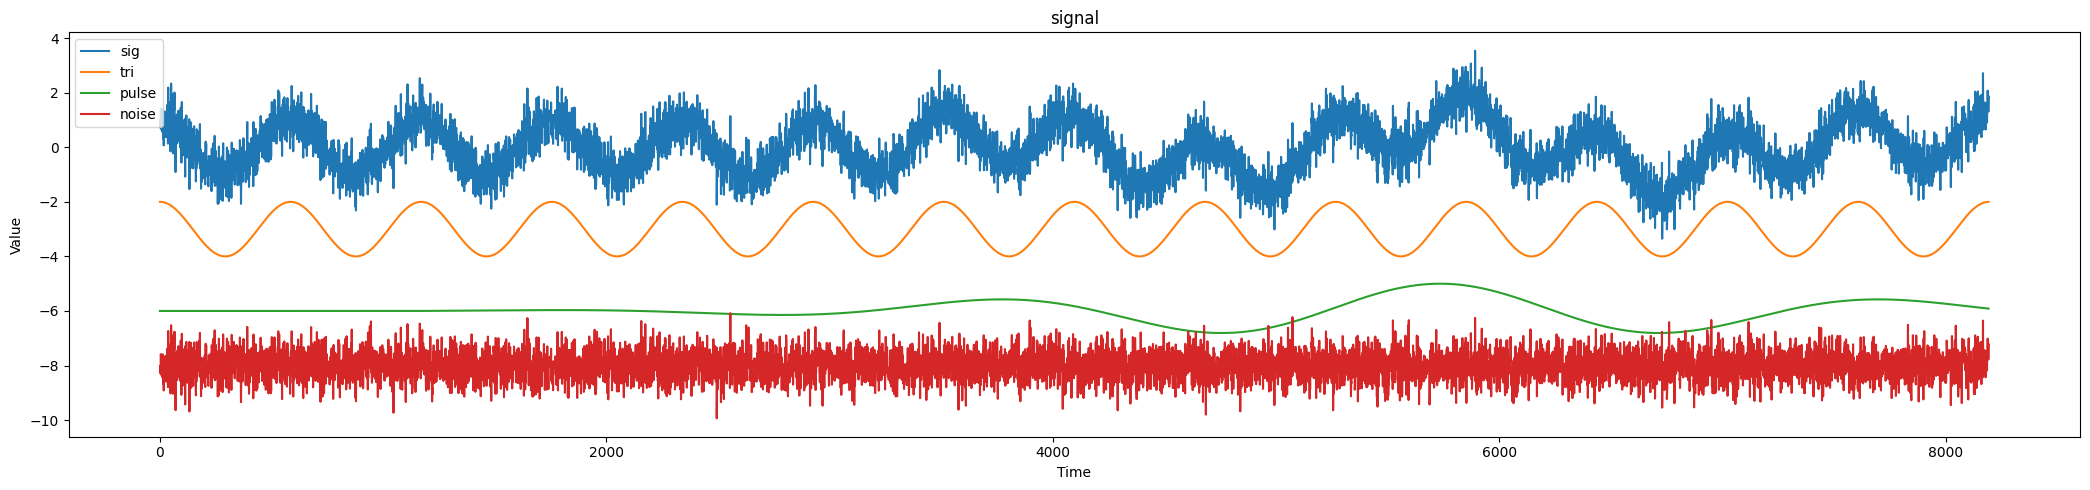

In [754]:
# signal
t = np.linspace(-1, 1, 2**13, endpoint=False)
tri = np.cos(2 * np.pi * 7 * t)
pulse = signal.gausspulse(t - 0.4, fc=2)
noise = np.random.normal(0,0.5,np.size(t))

tutorial  =  tri + pulse + noise

plot([tutorial, tri-3, pulse-6, noise-8], title="signal")
plt.legend(['sig', 'tri', 'pulse', 'noise'])

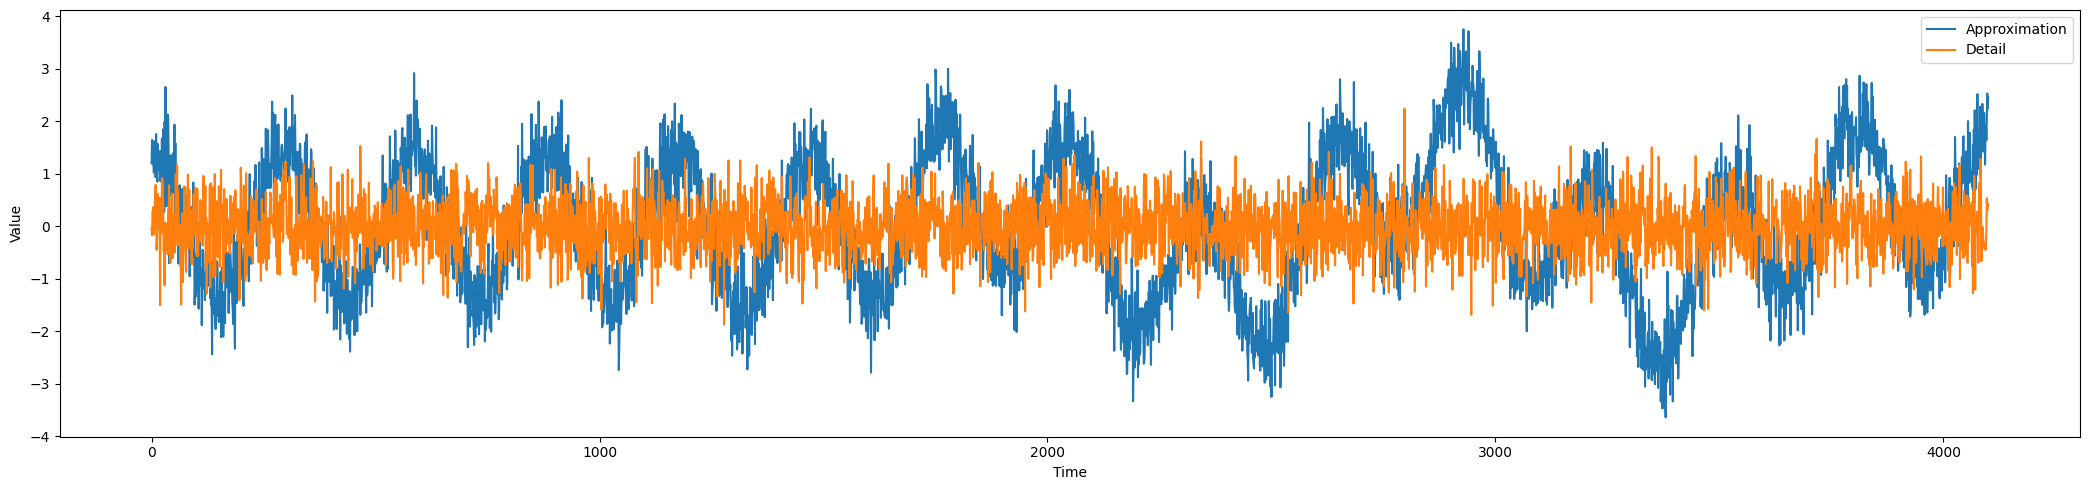

In [755]:
# DWT
width = np.arange(1, 31)
cA, cD = pywt.dwt(tutorial, 'db6')
plot([cA, cD])
plt.legend(['Approximation', 'Detail'])

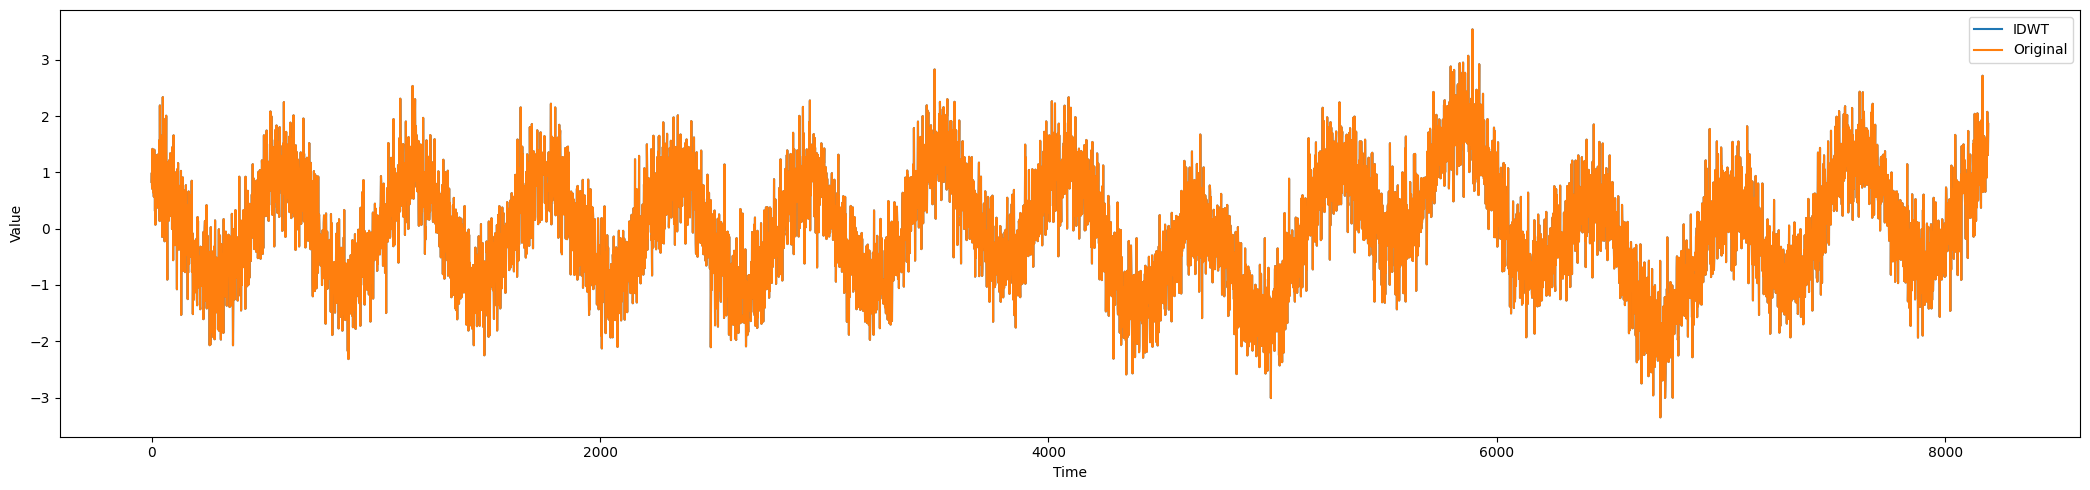

In [756]:
# IDWT
sig_r1 = pywt.idwt(cA, None ,'db6','smooth')
sig_r2 = pywt.idwt(None, cD ,'db6','smooth')
plot([sig_r1 + sig_r2, tutorial])
plt.legend(['IDWT', 'Original'])

## AWSOM

In [824]:
class AWSOM:
    def __init__(self, n_ls=[6, 4, 2], type="haar") -> None:
        """
        discover interesting patters and trends

        Attributes
        -------------------
        """
        if type != "haar":
            raise NotImplementedError
        self.n_ls = n_ls
        self.type = type
        self.depth = len(n_ls)
        self.k = sum(n_ls)

    def init_params(self, sig):
        self.current_t = len(sig)
        self.max_depth = int(np.log2(len(sig)))
        self.level = self.max_depth - self.depth + 1
        self.P = [np.zeros((self.k, self.k)) for _ in range(self.level)]
        self.q = [np.zeros((self.k,)) for _ in range(self.level)]
        self.beta = [np.zeros((self.k,)) for _ in range(self.level)]

        # wavelet transform
        V, W = [sig], [np.array(np.nan)]
        for _ in range(self.max_depth):
            _V, _W = pywt.dwt(V[-1], self.type)
            V.append(_V); W.append(_W)

        # pruning
        self.W = [np.array(np.nan)]+[Wi[-max(self.n_ls)-1:] for Wi in W[1:]]
        self.V = [Vi[-max(self.n_ls)-1:] for Vi in V]

        # prepare for variables
        for l in range(self.level):
            X, y = list(), list()
            for t in range(max(self.n_ls), W[l+1].shape[0]):
                _X = list()
                for d in range(self.depth):
                    _t = t//(2**d)
                    _X.append(W[l+d+1][_t-self.n_ls[d]: _t])
                _X = np.concatenate(_X)
                if _X.shape[0] == self.k:
                    X.append(_X); y.append(W[l+1][t])
            if X:
                X, y = np.array(X), np.array(y)
                self.P[l], self.q[l] = X.T@X, X.T@y
                try:
                    self.beta[l] = np.linalg.inv(self.P[l]) @ self.q[l]
                except np.linalg.LinAlgError:
                    self.beta[l] = np.linalg.pinv(self.P[l]) @ self.q[l]
            else:
                break

    def update_crest(self, x_t):
        updated_W_levels = list()
        #TODO: "db6"にも対応させる必要あり
        for l in range(self.max_depth-1):
            if (self.current_t+1) % (2**l) == 0:
                self.__compute_V(l, x_t)
            if (self.current_t+1) % (2**(l+1)) == 0:
                self.__compute_W(l+1)
                updated_W_levels.append(l+1)
        self.current_t += 1

        return updated_W_levels

    def update(self, x_t):
        updated_W_levels = self.update_crest(x_t)
        for l in updated_W_levels:
            X = np.concatenate([Wi[-ni-1: -1] for Wi, ni in zip(self.W[l: l+self.depth], self.n_ls)])
            y = self.W[l][-1]
            if X.shape[0] == self.k:
                self.P[l] += X@X.T
                self.q[l] += y*X

    def model_selection(self):
        raise NotImplementedError

    def predict(self, st, interval):
        W = copy.deepcopy(self.W)
        W_preds = [np.array([])] * self.level
        for t in range(st, st+interval):
            for l in range(self.level):
                if t % (2**(l+1)) == 0:
                    X = np.concatenate([Wi[-ni:] for Wi, ni in zip(W[l+1: l+self.depth+1], self.n_ls)])
                    if X.shape[0] == self.k:
                        W_pred = X@self.beta[l]
                        W_preds[l] = np.append(W_preds[l], W_pred)
        W_preds = [pred for pred in W_preds if len(pred)]
        W_preds.append(np.zeros_like(W_preds[-1])+max(self.V[-1]))
        W_preds = W_preds[::-1]
        # for i in W_preds:
        #     print(i.shape)
        return pywt.waverec(W_preds, self.type)

    def __compute_V(self, level, x_t):
        if level==0:
            self.V[0] = self.__fifo(self.V[0], x_t)
        else:
            V_new = pywt.dwt(self.V[level-1][-2:], self.type)[0]
            self.V[level] = self.__fifo(self.V[level], V_new)

    def __compute_W(self, level):
        W_new = pywt.dwt(self.V[level-1][-2:], self.type)[1]
        self.W[level] = self.__fifo(self.W[level], W_new)

    def __fifo(self, datas, new_data):
        return np.delete(np.append(datas, new_data), 0)

## Experiment

(<Figure size 2100x500 with 1 Axes>,
 <Axes: title={'center': 'Triangle'}, xlabel='Time', ylabel='Value'>)

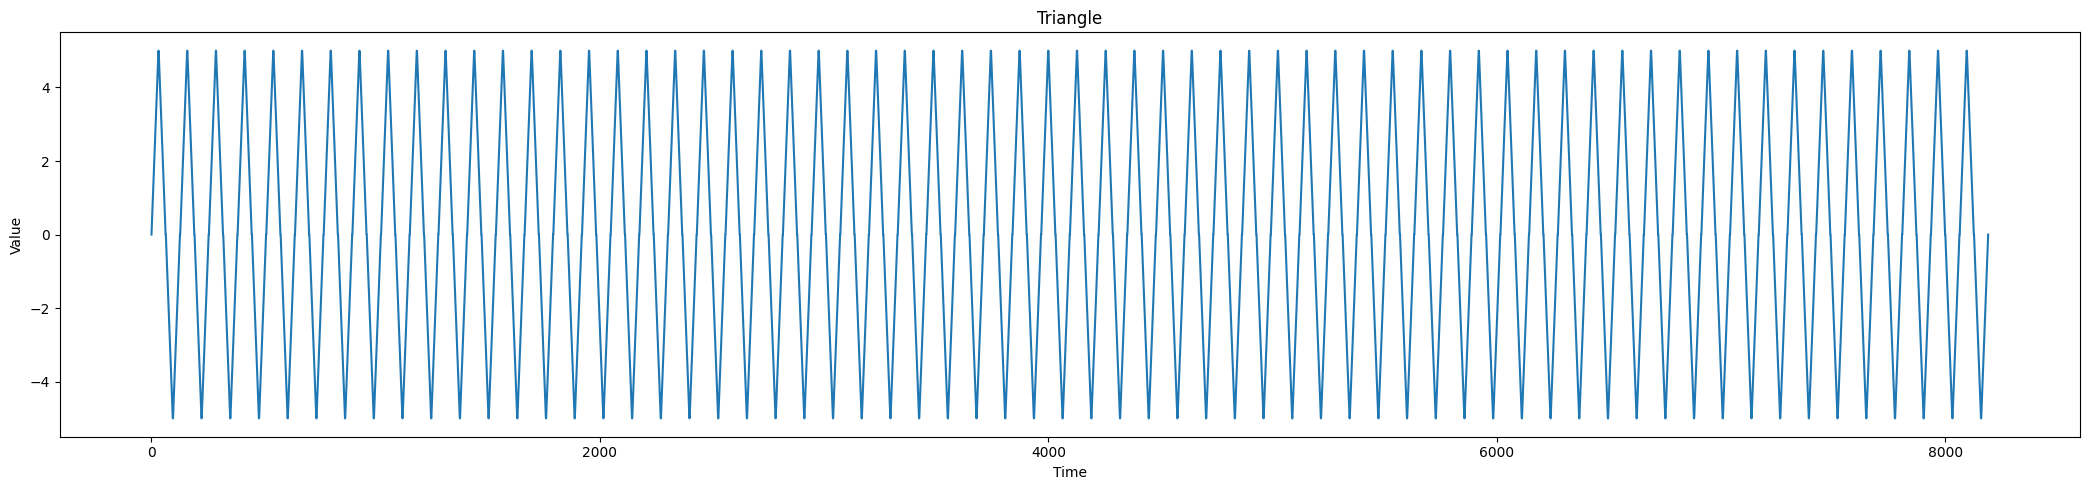

In [849]:
triangle = generate_triangles(length=2**13, period=128)
plot([triangle], title="Triangle")

(<Figure size 2100x500 with 1 Axes>,
 <Axes: title={'center': 'Mix'}, xlabel='Time', ylabel='Value'>)

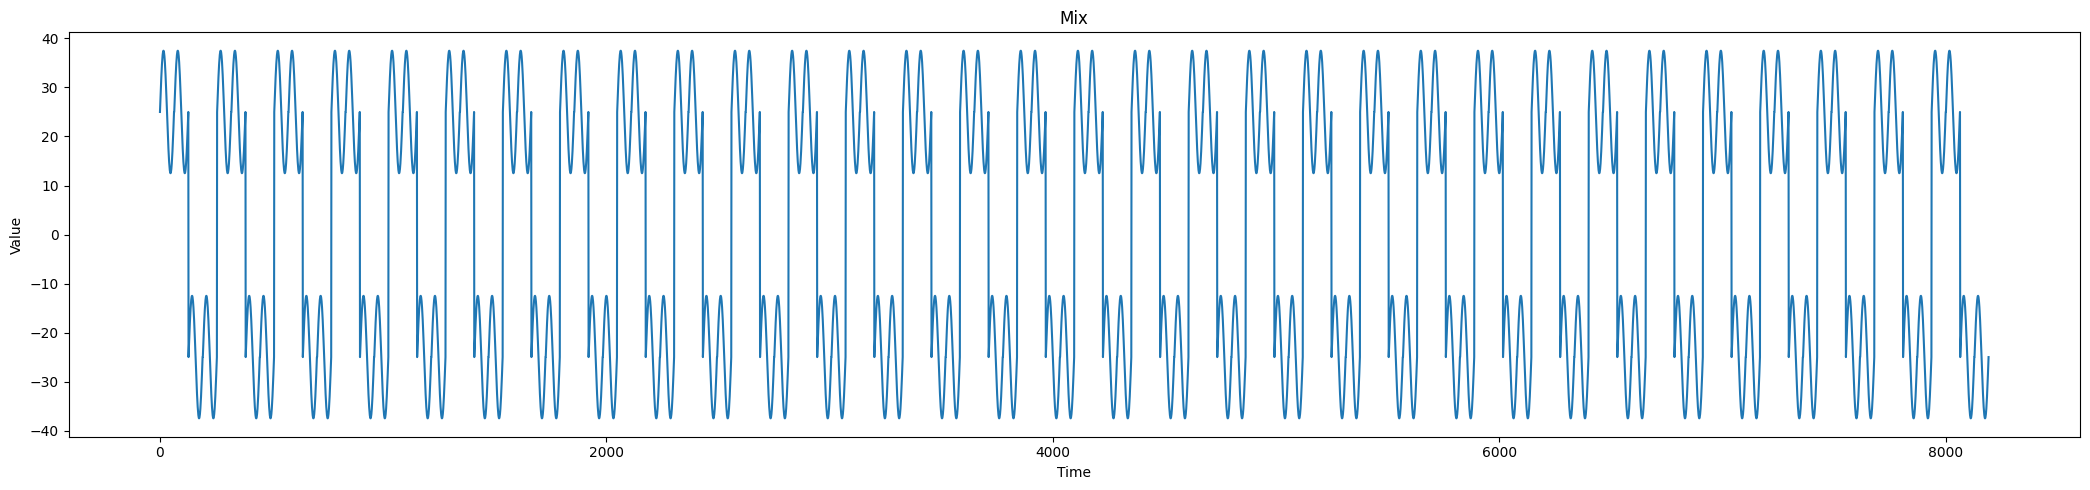

In [782]:
mix = generate_mix(length=2**13)
plot([mix], title="Mix")

(<Figure size 2100x500 with 1 Axes>,
 <Axes: title={'center': 'Impulse'}, xlabel='Time', ylabel='Value'>)

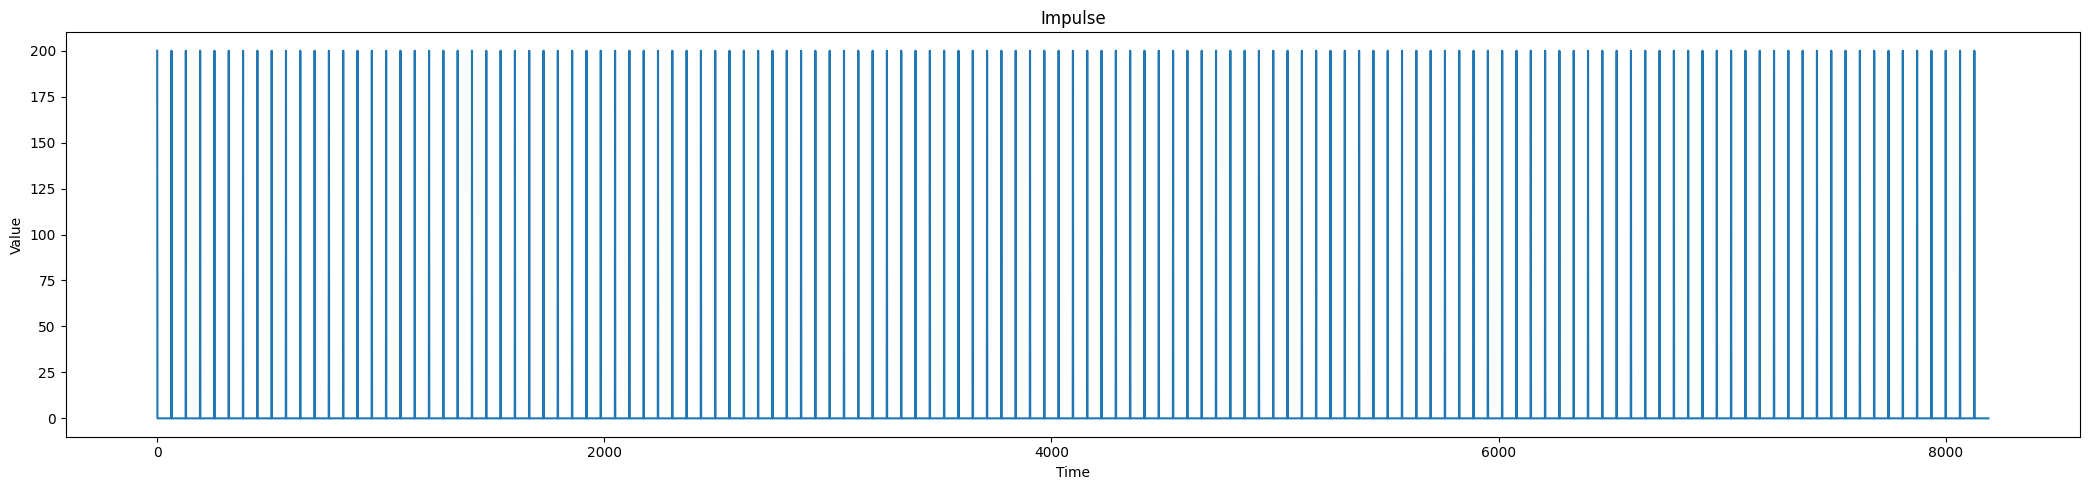

In [829]:
impulse = generate_impulses(length=2**13, period=64)
plot([impulse], title="Impulse")

(<Figure size 2100x500 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

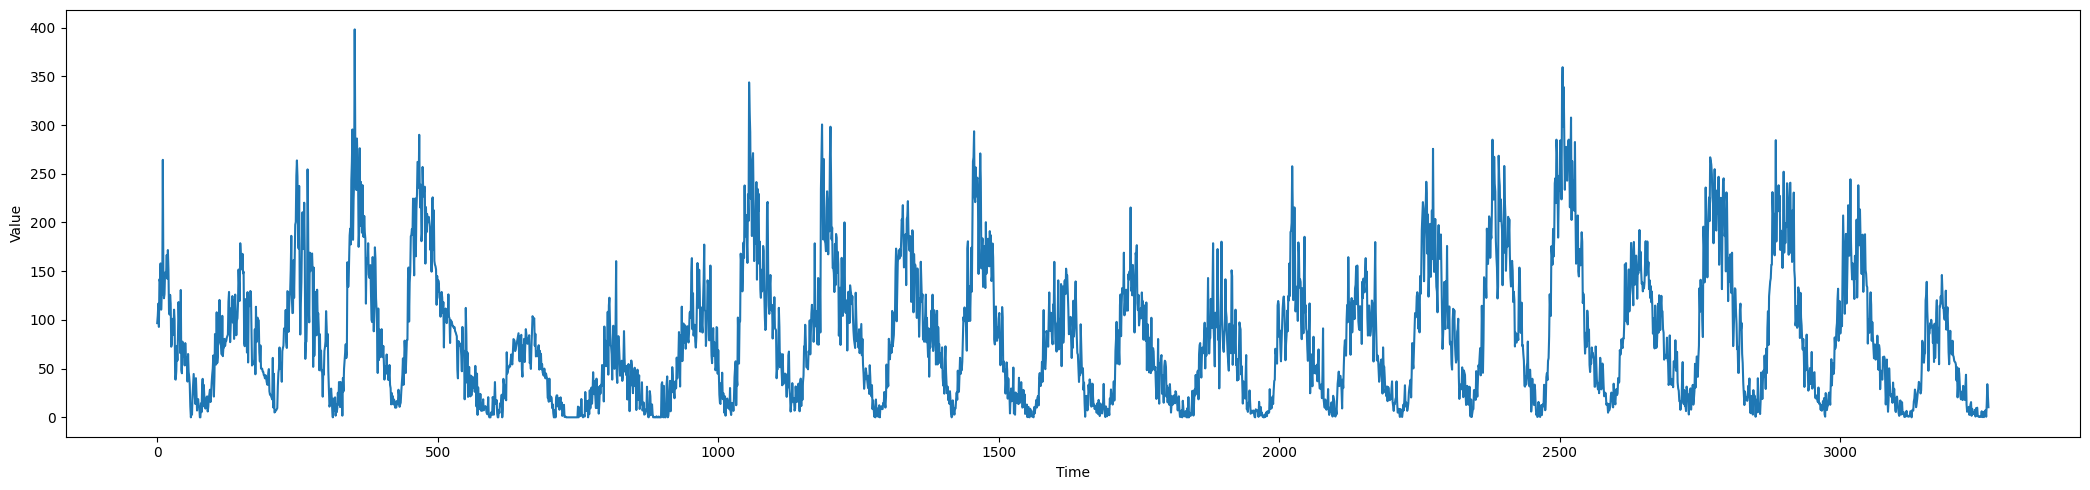

In [856]:
df = pd.read_csv('../_data/Sunspots.csv')
X = df['Monthly Mean Total Sunspot Number'].values
sunspots = df['Monthly Mean Total Sunspot Number']
plot([df['Monthly Mean Total Sunspot Number']])

(<Figure size 2100x500 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

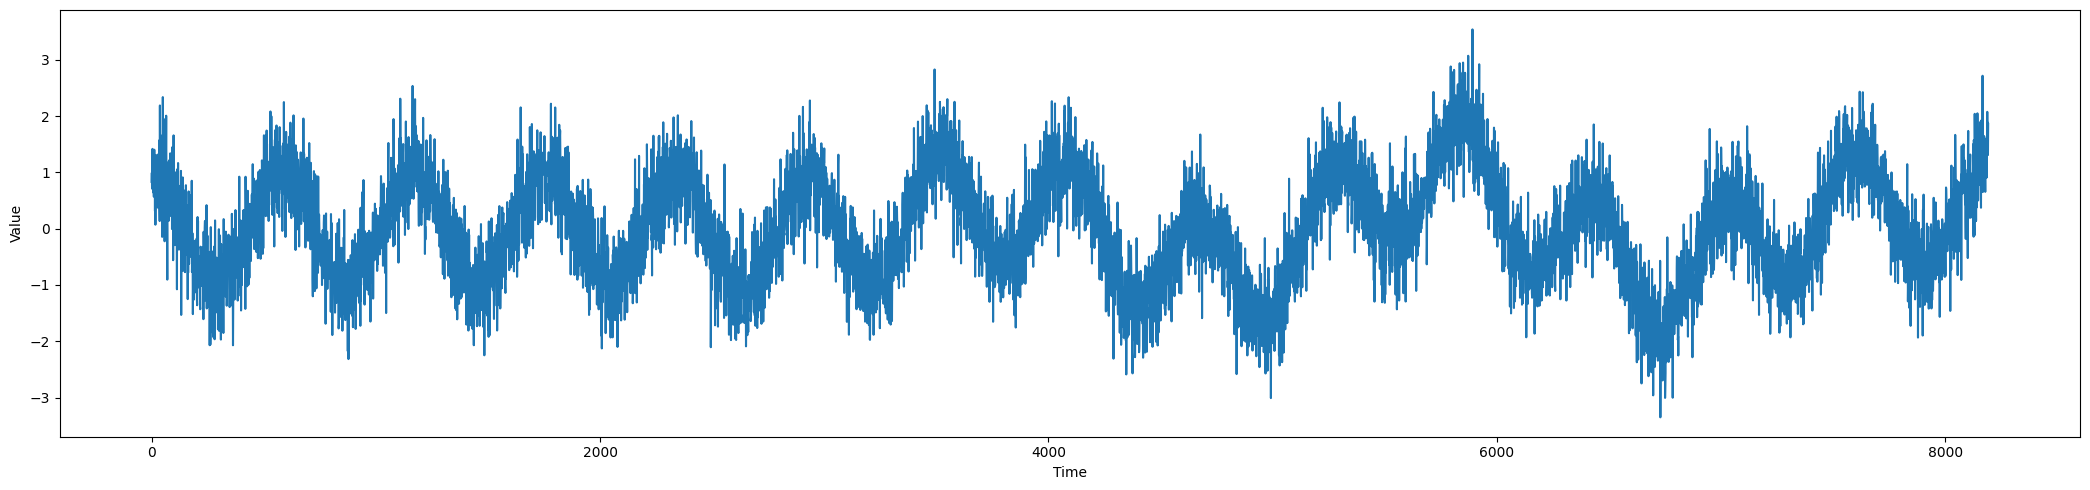

In [764]:
plot([tutorial])

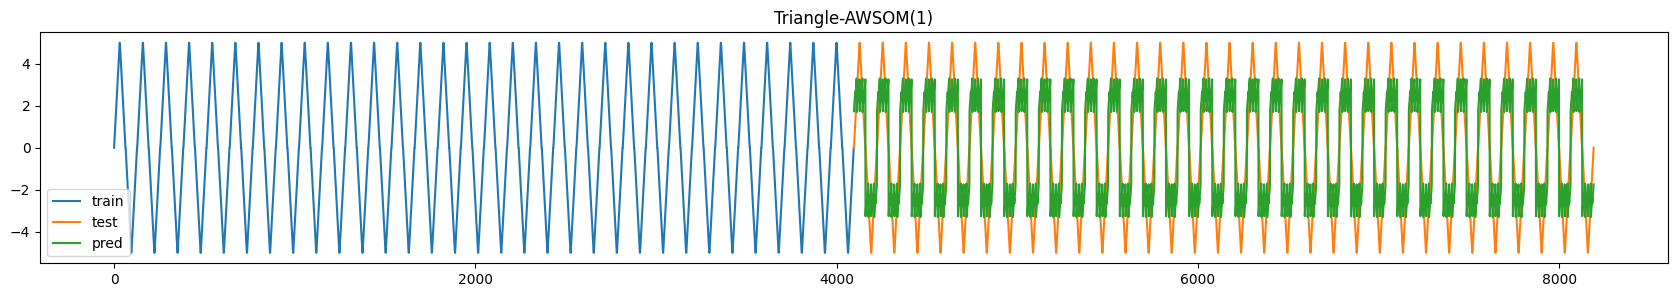

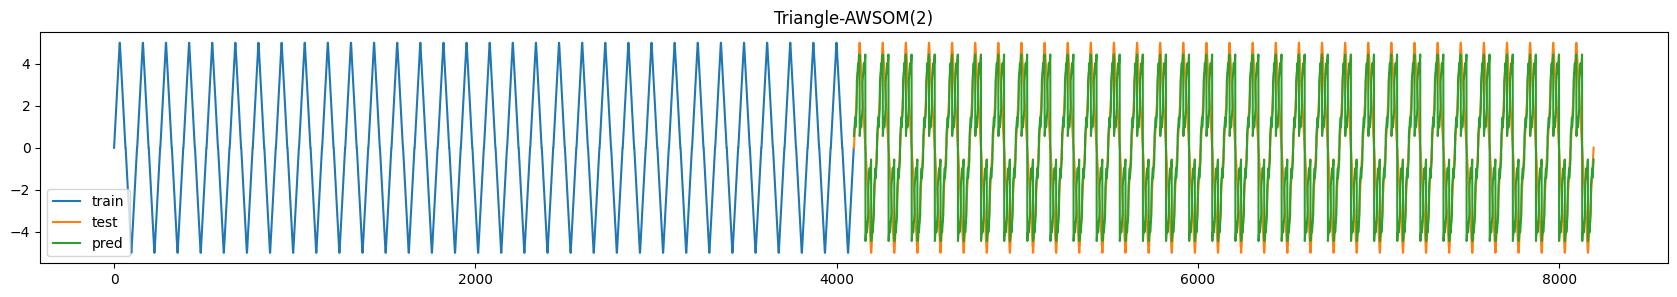

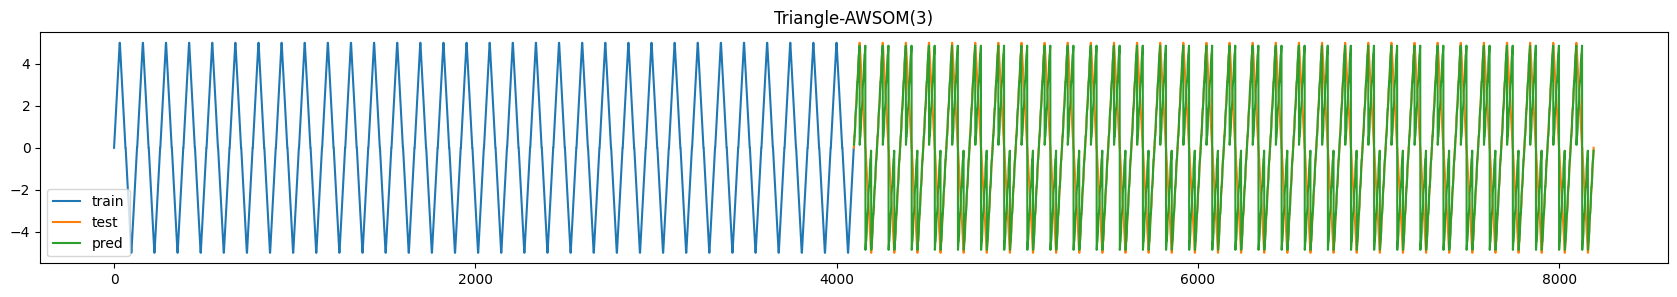

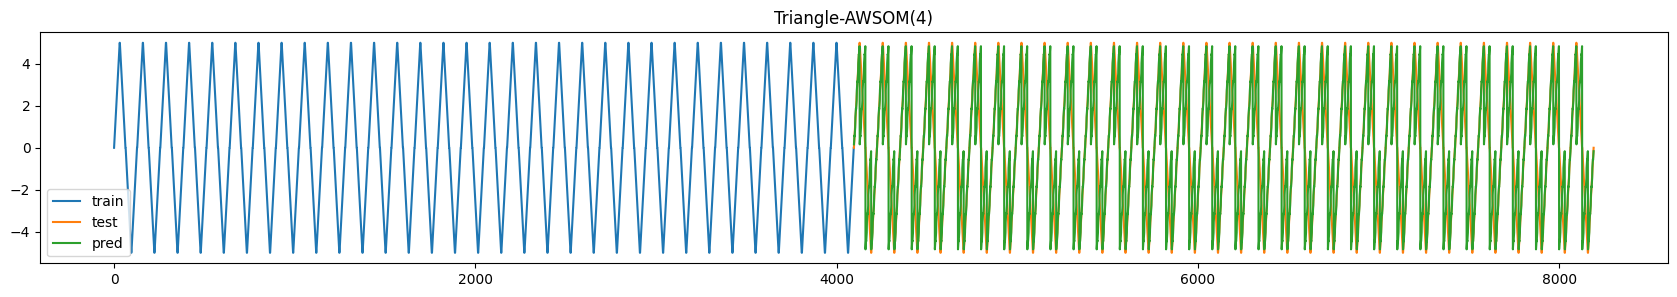

In [850]:
for i in range(1, 5):
    n_ls = [i]
    sig = triangle
    base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

    awsom = AWSOM(n_ls=n_ls, type="haar")
    awsom.init_params(sig[:base_point])

    old_t = awsom.current_t
    for t in range(base_point, update_point):
        awsom.update(sig[t])

    pred = awsom.predict(update_point, interval=test_point-update_point)
    plt.figure(figsize=(21, 3))
    plt.title(f"Triangle-AWSOM({n_ls[0]})")
    plt.plot(np.arange(update_point), sig[:update_point])
    plt.plot(np.arange(update_point, test_point), sig[update_point:])
    plt.plot(np.arange(update_point, test_point), pred)

    plt.legend(["train", "test", "pred"])

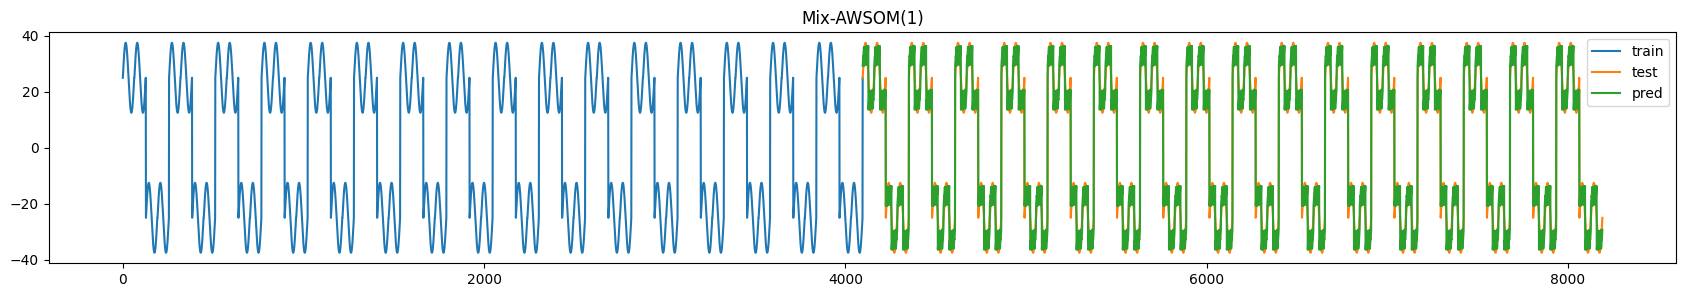

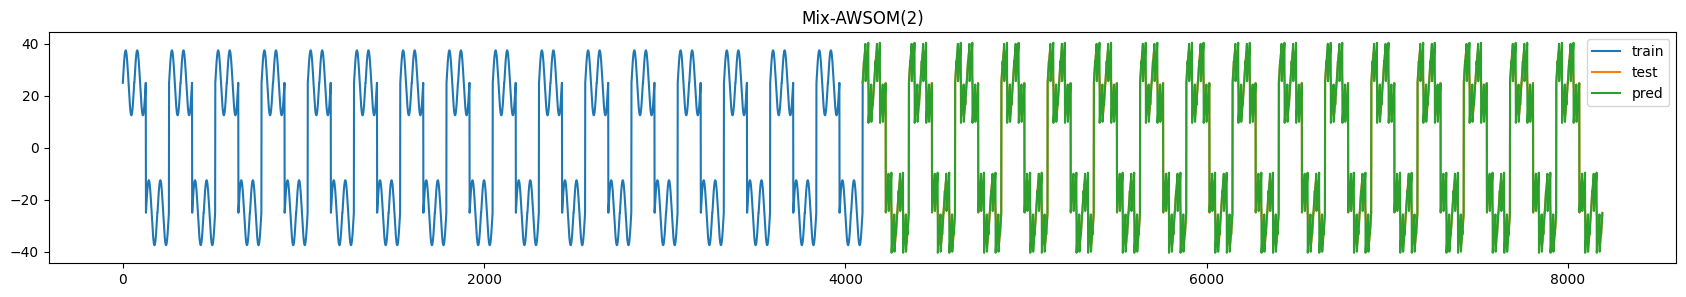

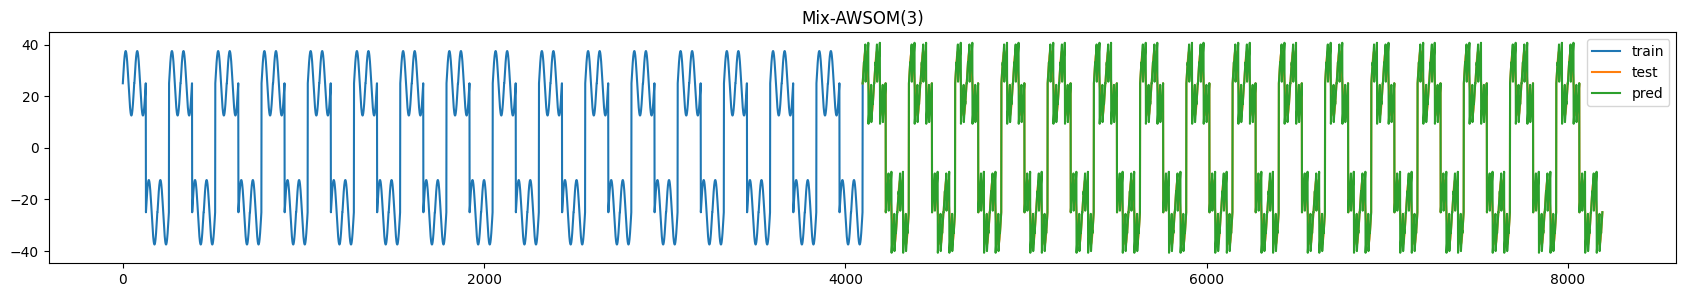

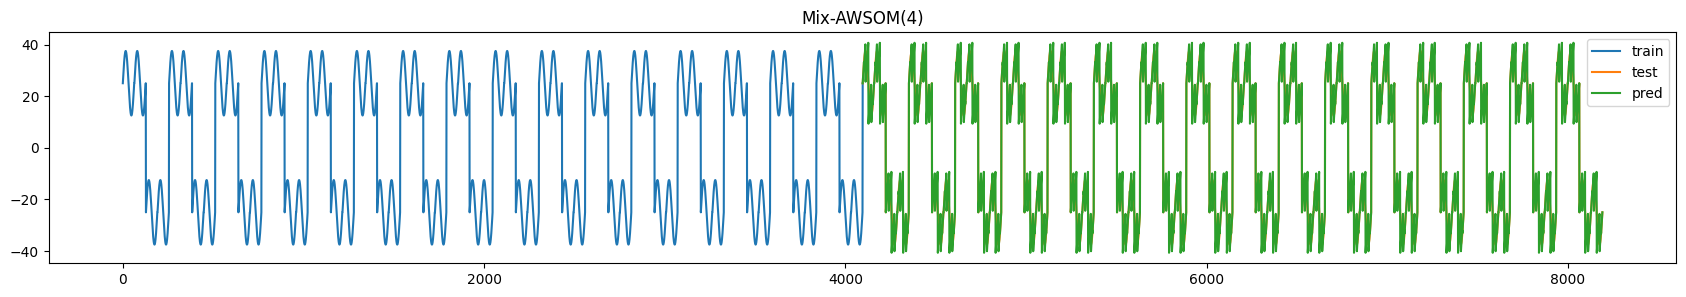

In [851]:
for i in range(1, 5):
    n_ls = [i]
    sig = mix
    base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

    awsom = AWSOM(n_ls=n_ls, type="haar")
    awsom.init_params(sig[:base_point])

    old_t = awsom.current_t
    for t in range(base_point, update_point):
        awsom.update(sig[t])

    pred = awsom.predict(update_point, interval=test_point-update_point)
    plt.figure(figsize=(21, 3))
    plt.title(f"Mix-AWSOM({n_ls[0]})")
    plt.plot(np.arange(update_point+1), sig[:update_point+1])
    plt.plot(np.arange(update_point, test_point), sig[update_point:])
    plt.plot(np.arange(update_point, test_point), pred)

    plt.legend(["train", "test", "pred"])

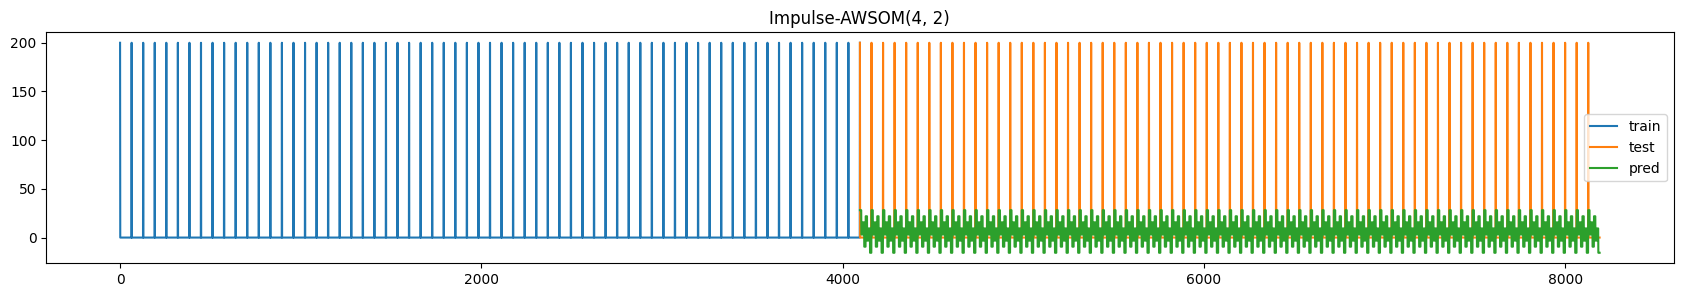

In [837]:
n_ls = [4, 2]
sig = impulse
base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

awsom = AWSOM(n_ls=n_ls, type="haar")
awsom.init_params(sig[:base_point])

old_t = awsom.current_t
for t in range(base_point, update_point):
    awsom.update(sig[t])

pred = awsom.predict(update_point, interval=test_point-update_point)
plt.figure(figsize=(21, 3))
plt.title(f"Impulse-AWSOM(4, 2)")
plt.plot(np.arange(update_point+1), sig[:update_point+1])
plt.plot(np.arange(update_point, test_point), sig[update_point:])
plt.plot(np.arange(update_point, test_point), pred)

plt.legend(["train", "test", "pred"])

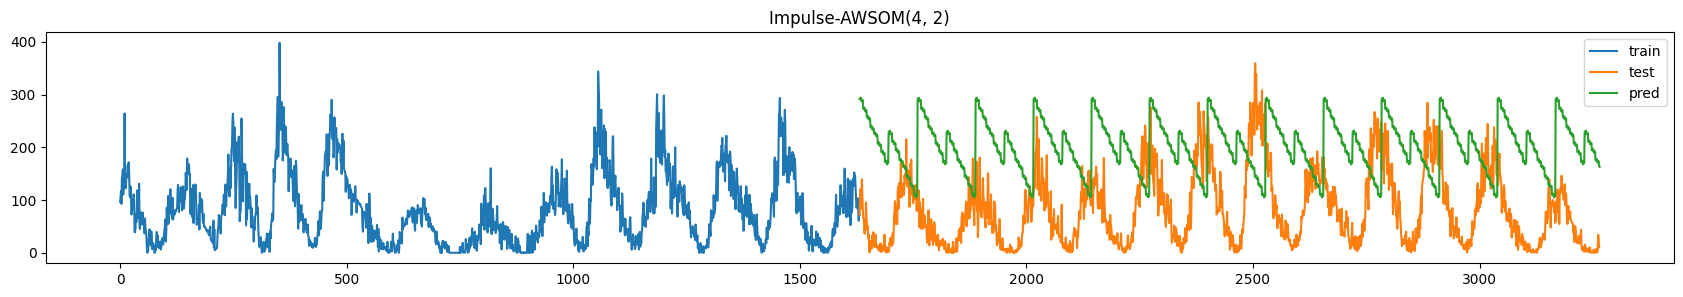

In [863]:
n_ls = [5]
sig = sunspots
base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

awsom = AWSOM(n_ls=n_ls, type="haar")
awsom.init_params(sig[:base_point])

old_t = awsom.current_t
for t in range(base_point, update_point):
    awsom.update(sig[t])

pred = awsom.predict(update_point, interval=test_point-update_point)
plt.figure(figsize=(21, 3))
plt.title(f"Impulse-AWSOM(4, 2)")
plt.plot(np.arange(update_point+1), sig[:update_point+1])
plt.plot(np.arange(update_point, test_point), sig[update_point:])
plt.plot(np.arange(update_point, test_point+1), pred)

plt.legend(["train", "test", "pred"])

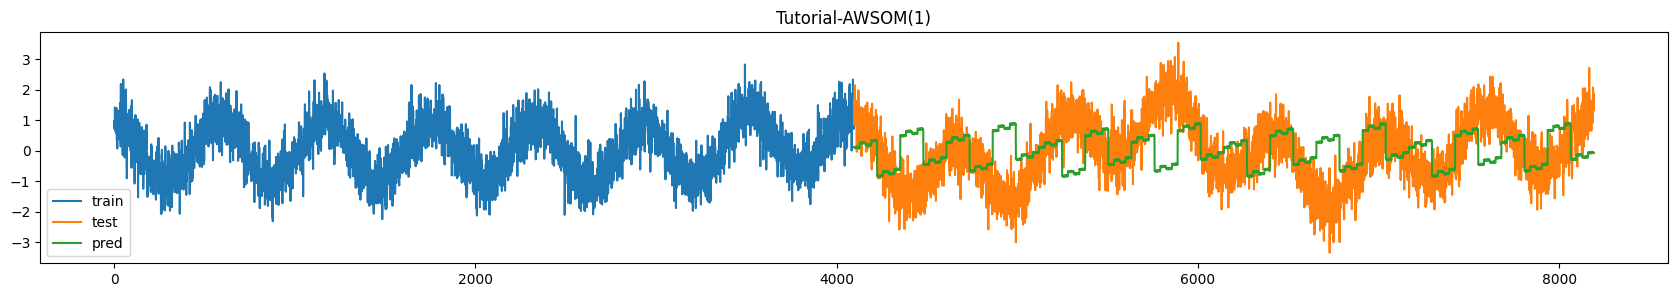

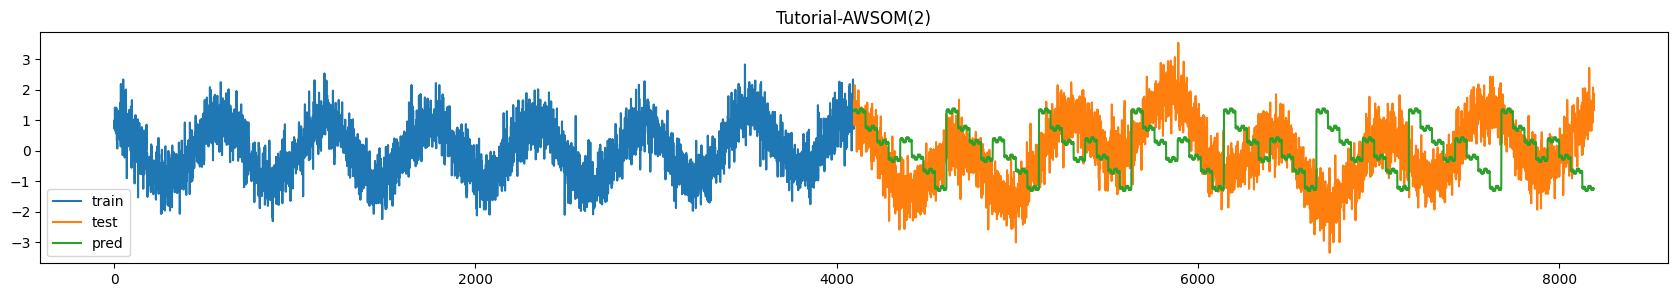

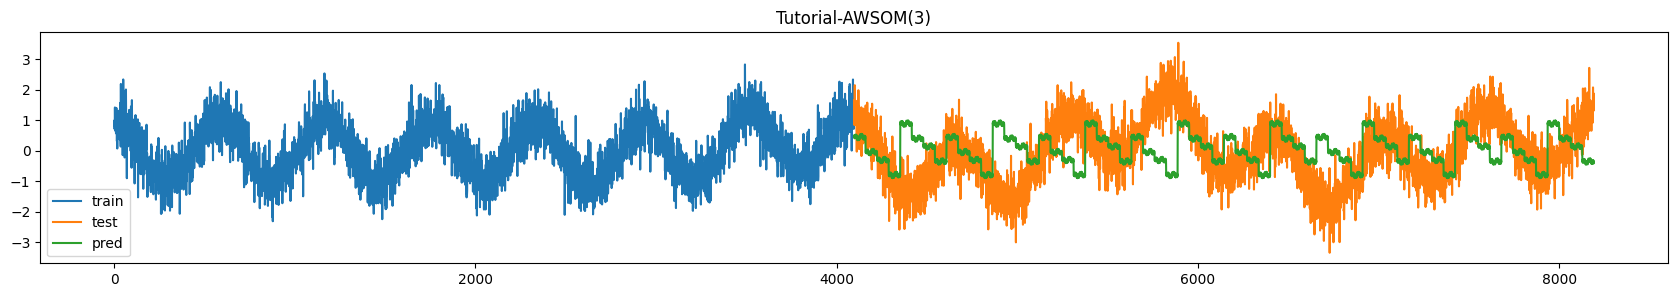

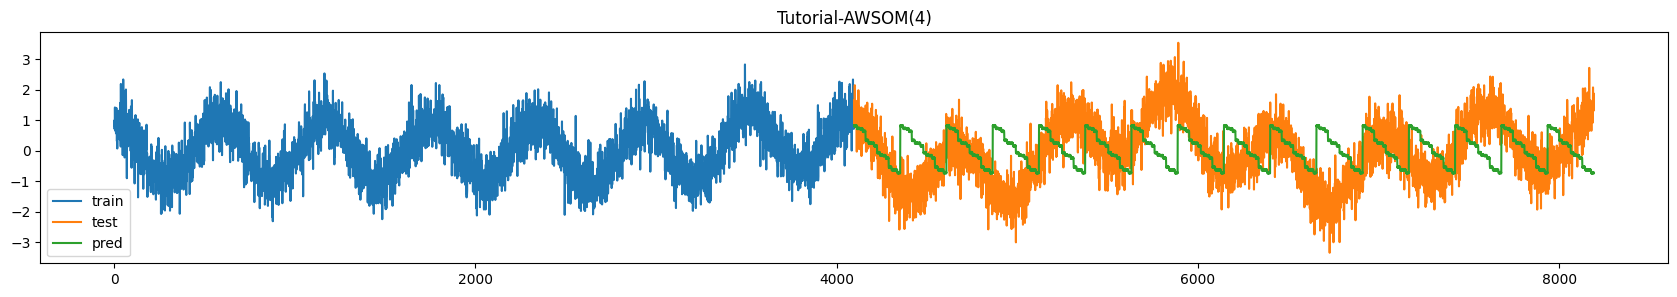

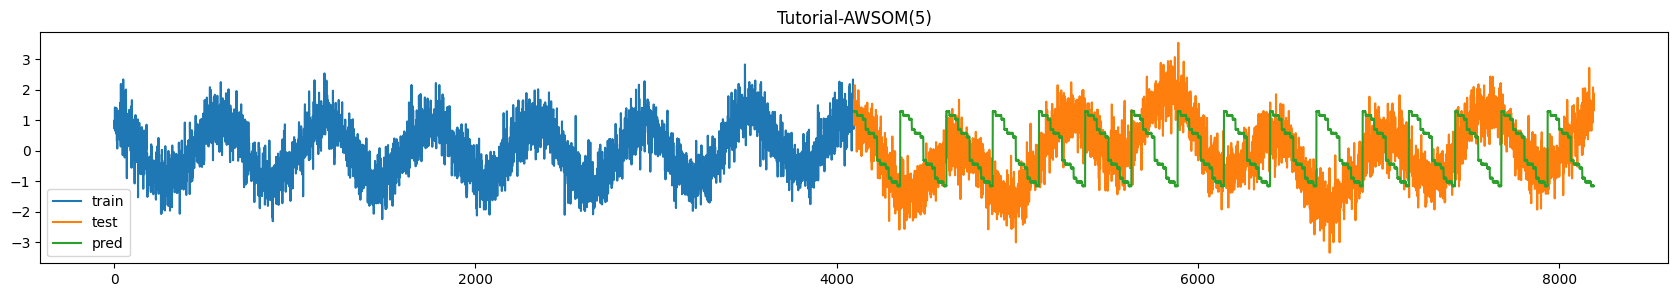

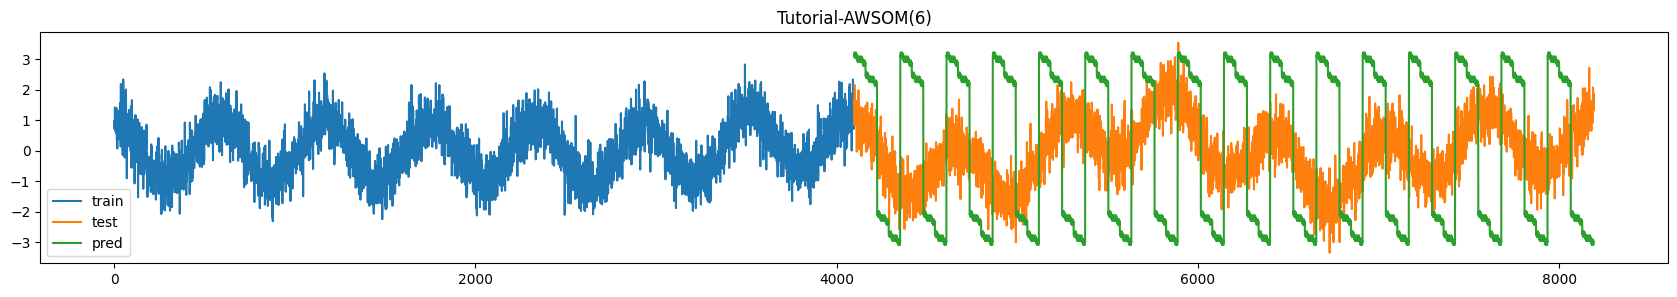

In [838]:
for i in range(1, 7):
    n_ls = [i]
    sig = tutorial
    base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

    awsom = AWSOM(n_ls=n_ls, type="haar")
    awsom.init_params(sig[:base_point])

    old_t = awsom.current_t
    for t in range(base_point, update_point):
        awsom.update(sig[t])

    pred = awsom.predict(update_point, interval=test_point-update_point)
    plt.figure(figsize=(21, 3))
    plt.title(f"Tutorial-AWSOM({n_ls[0]})")
    plt.plot(np.arange(update_point), sig[:update_point])
    plt.plot(np.arange(update_point, test_point), sig[update_point:])
    plt.plot(np.arange(update_point, test_point), pred)

    plt.legend(["train", "test", "pred"])

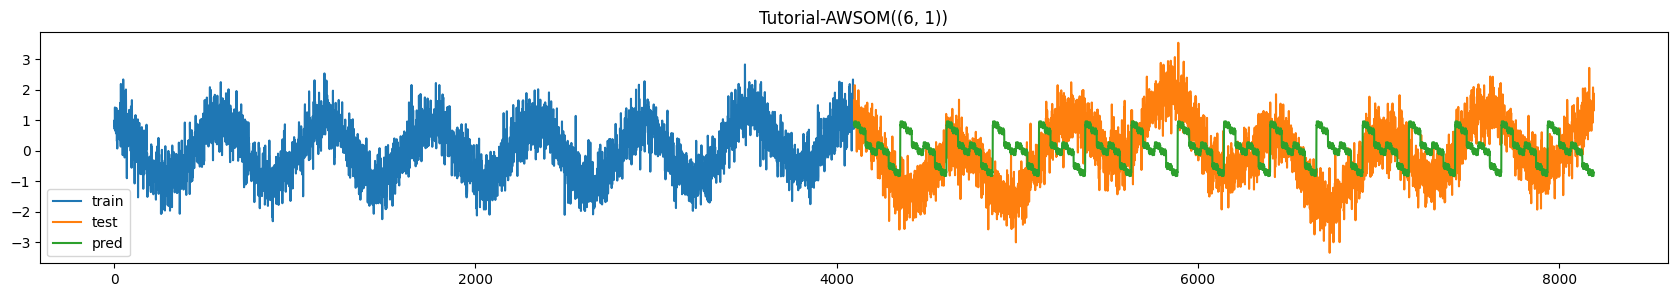

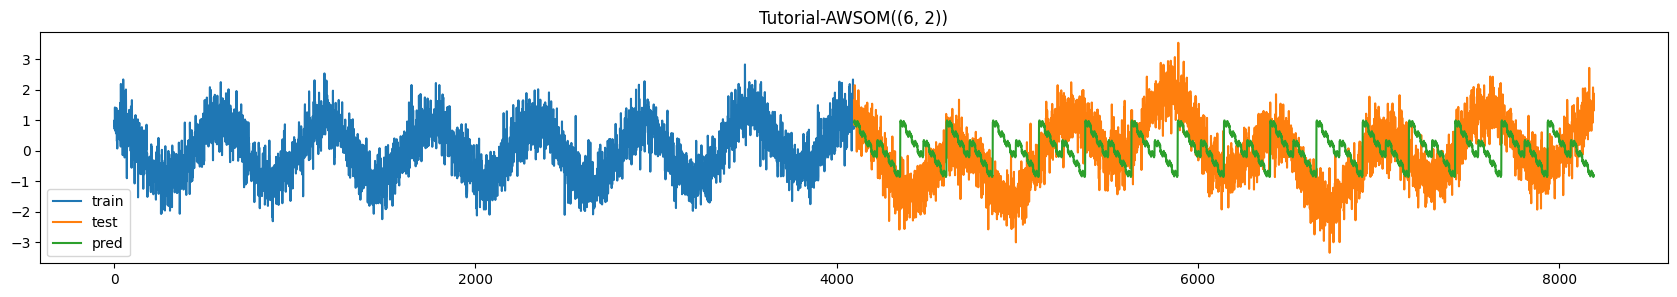

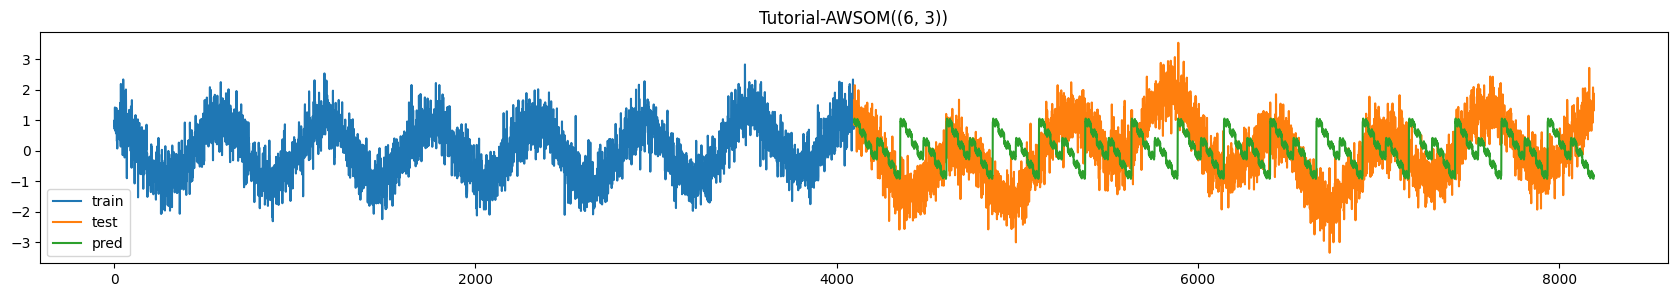

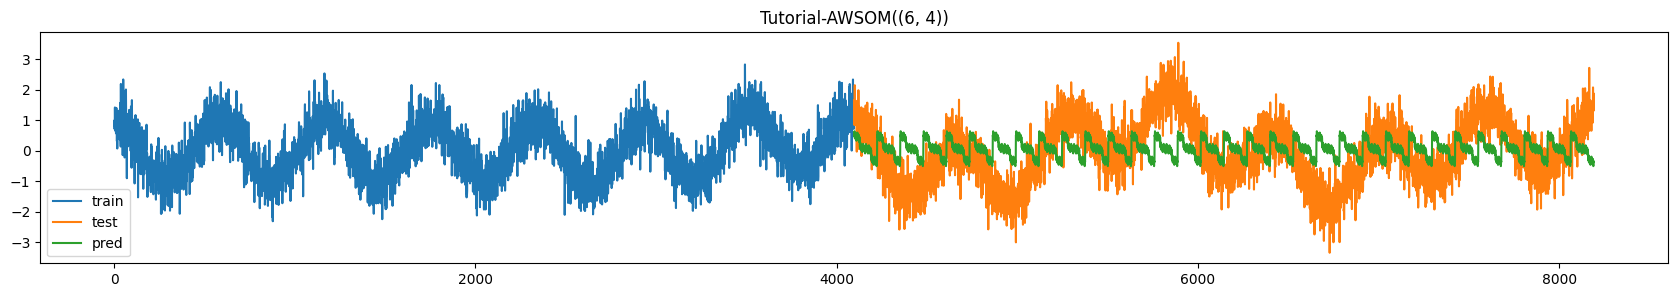

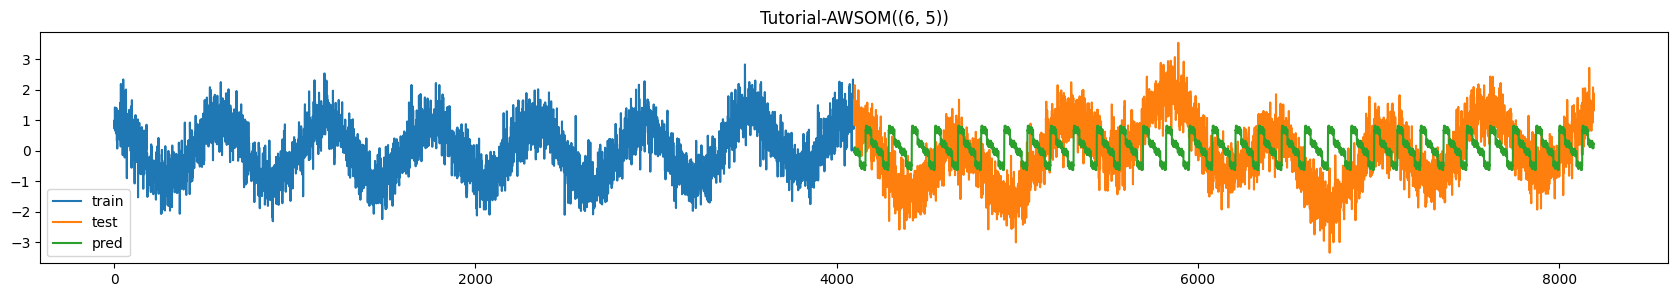

In [839]:
for i in range(1, 6):
    n_ls = [6, i]
    sig = tutorial
    base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

    awsom = AWSOM(n_ls=n_ls, type="haar")
    awsom.init_params(sig[:base_point])

    old_t = awsom.current_t
    for t in range(base_point, update_point):
        awsom.update(sig[t])

    pred = awsom.predict(update_point, interval=test_point-update_point)
    plt.figure(figsize=(21, 3))
    plt.title(f"Tutorial-AWSOM({n_ls[0], n_ls[1]})")
    plt.plot(np.arange(update_point), sig[:update_point])
    plt.plot(np.arange(update_point, test_point), sig[update_point:])
    plt.plot(np.arange(update_point, test_point), pred)

    plt.legend(["train", "test", "pred"])

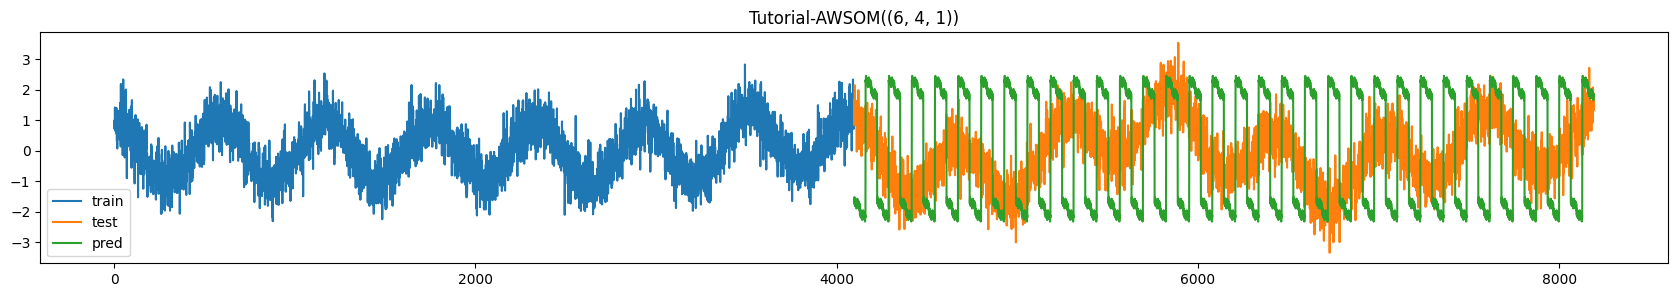

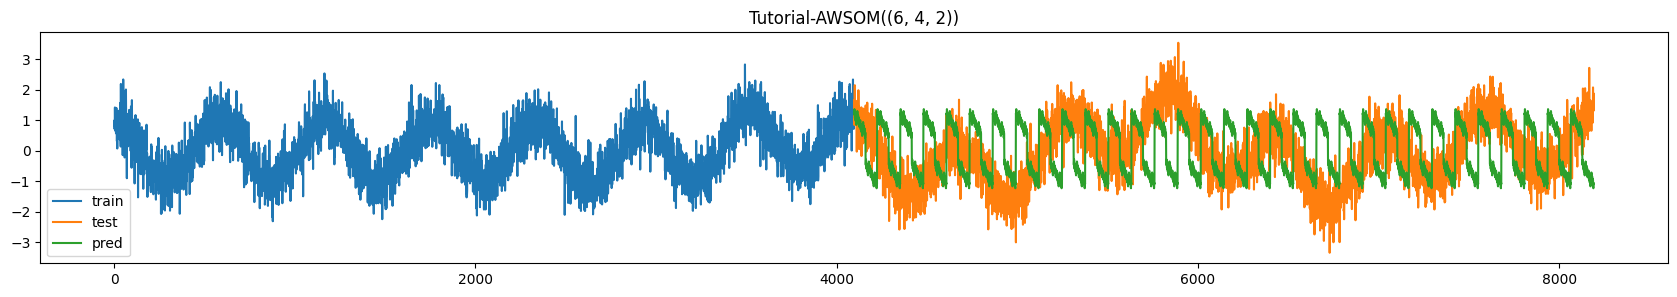

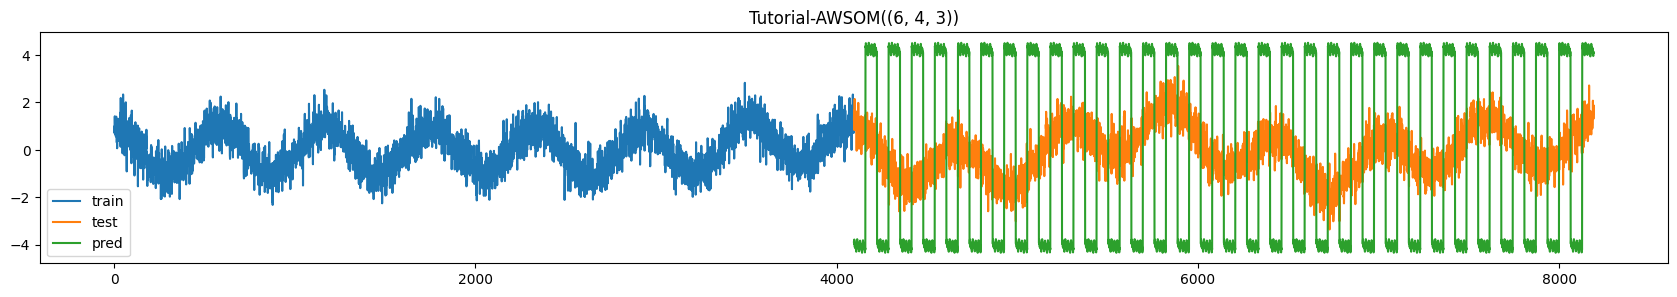

In [840]:
for i in range(1, 4):
    n_ls = [6, 4, i]
    sig = tutorial
    base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

    awsom = AWSOM(n_ls=n_ls, type="haar")
    awsom.init_params(sig[:base_point])

    old_t = awsom.current_t
    for t in range(base_point, update_point):
        awsom.update(sig[t])

    pred = awsom.predict(update_point, interval=test_point-update_point)
    plt.figure(figsize=(21, 3))
    plt.title(f"Tutorial-AWSOM({n_ls[0], n_ls[1], n_ls[2]})")
    plt.plot(np.arange(update_point), sig[:update_point])
    plt.plot(np.arange(update_point, test_point), sig[update_point:])
    plt.plot(np.arange(update_point, test_point), pred)

    plt.legend(["train", "test", "pred"])